In [2]:
import pandas as pd
import numpy as np
from datasets import load_dataset

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
dataset_train = load_dataset("stanfordnlp/SHP", split="train")
dataset_val = load_dataset("stanfordnlp/SHP", split="validation")
print("The length of the training dataset is", len(dataset_train))
print("The length of the validation dataset is", len(dataset_val))

Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

The length of the training dataset is 348718
The length of the validation dataset is 18436


In [18]:
dataset_train = pd.DataFrame(dataset_train)
data_train = dataset_train.drop(columns=['post_id', 'domain', 'upvote_ratio', 'c_root_id_A', 'c_root_id_B','created_at_utc_A', 'created_at_utc_B','score_A','score_B','seconds_difference','score_ratio'])
data_train.head()

,history,human_ref_A,human_ref_B,labels
0,In an interview right before receiving the 201...,Currently wrapping up my PhD. There is a stark...,It’s ironic to me that research has shown that...,0
1,If any professor is reading this: please do no...,And when your teacher doesn't listen or pay at...,"I'm pretty strict on time, to the point where ...",0
2,If any professor is reading this: please do no...,Profs can be oblivious? What’s new!,This sounds like a problem with a specific pro...,0
3,If any professor is reading this: please do no...,This sounds like a problem with a specific pro...,And when your teacher doesn't listen or pay at...,1
4,If any professor is reading this: please do no...,This would be totally unacceptable in my class...,This sounds like a problem with a specific pro...,0


In [19]:
dataset_val = pd.DataFrame(dataset_val)
data_val = dataset_val.drop(columns=['post_id', 'domain', 'upvote_ratio', 'c_root_id_A', 'c_root_id_B','created_at_utc_A', 'created_at_utc_B','score_A','score_B','seconds_difference','score_ratio'])
data_val.head()

,history,human_ref_A,human_ref_B,labels
0,"""40% of Ph.D. students in the UK at high risk ...","I agree with the other comment about funding, ...","For starters, have proper bloody funding. I me...",1
1,"""40% of Ph.D. students in the UK at high risk ...","You say ""I had no clue my written work was so ...","I agree with the other comment about funding, ...",0
2,"""40% of Ph.D. students in the UK at high risk ...","You say ""I had no clue my written work was so ...","For starters, have proper bloody funding. I me...",0
3,"""40% of Ph.D. students in the UK at high risk ...","You say ""I had no clue my written work was so ...",UCU is mounting a 'PGRs as staff' campaign to ...,0
4,"""40% of Ph.D. students in the UK at high risk ...",don't just assume thesis advisors know how to ...,"You say ""I had no clue my written work was so ...",1


# Data Cleaning and Tokenization

In [20]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    # delete extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # delete single characters
    text = ' '.join([word for word in text.split() if len(word) > 1])
    # text = ' '.join(text.split()[:256])
    return text

In [21]:
# delete stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    word_tokens = word_tokenize(text)
    text = ' '.join([word for word in word_tokens if word not in stop_words])
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/crinstaniev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/crinstaniev/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [22]:
import torch
from torch.utils.data import Dataset, DataLoader
import transformers
from transformers import BertTokenizer, BertModel
from torch import nn, optim
from tqdm import tqdm

transformers.logging.set_verbosity_error()

In [23]:
tokenizer = BertTokenizer.from_pretrained('google/bert_uncased_L-2_H-128_A-2')

In [24]:
data_train.dropna(inplace=True)
train_data = []
for i in tqdm(range(len(data_train))):
  post = data_train.iloc[i]['history']
  summary_0 = data_train.iloc[i]['human_ref_A']
  summary_1 = data_train.iloc[i]['human_ref_B']
  label = data_train.iloc[i]['labels']

  # clean the text
  post = clean_text(post)
  post = remove_stopwords(post)
  summary_0 = clean_text(summary_0)
  summary_0 = remove_stopwords(summary_0)
  summary_1 = clean_text(summary_1)
  summary_1 = remove_stopwords(summary_1)

  in_0 = post + ' [SEP] ' + summary_0
  in_1 = post + ' [SEP] ' + summary_1

  # tokenize the input and only take the input_ids
  in_0 = tokenizer(in_0, max_length=512, add_special_tokens=True, truncation=True)['input_ids']
  in_1 = tokenizer(in_1, max_length=512, add_special_tokens=True, truncation=True)['input_ids']

  train_data.append((in_0, in_1, label))

100%|██████████| 348718/348718 [16:31<00:00, 351.79it/s] 


In [25]:
data_val.dropna(inplace=True)
val_data = []
for i in tqdm(range(len(data_val))):
  post = data_val.iloc[i]['history']
  summary_0 = data_val.iloc[i]['human_ref_A']
  summary_1 = data_val.iloc[i]['human_ref_B']
  label = data_val.iloc[i]['labels']

  # clean the text
  post = clean_text(post)
  post = remove_stopwords(post)
  summary_0 = clean_text(summary_0)
  summary_0 = remove_stopwords(summary_0)
  summary_1 = clean_text(summary_1)
  summary_1 = remove_stopwords(summary_1)

  in_0 = post + ' [SEP] ' + summary_0
  in_1 = post + ' [SEP] ' + summary_1

  # tokenize the input and only take the input_ids
  in_0 = tokenizer(in_0, max_length=512, add_special_tokens=True, truncation=True)['input_ids']
  in_1 = tokenizer(in_1, max_length=512, add_special_tokens=True, truncation=True)['input_ids']

  val_data.append((in_0, in_1, label))

100%|██████████| 18436/18436 [00:50<00:00, 365.25it/s]


In [26]:
print(train_data[5][0])
print(train_data[5][1])

[101, 2934, 3752, 3531, 8489, 2493, 4363, 18216, 2172, 2936, 2056, 4472, 15571, 5793, 3696, 18333, 2791, 14652, 3531, 2425, 2493, 2562, 18216, 3056, 3091, 8489, 3924, 2175, 2275, 2051, 5787, 2431, 3178, 8489, 2147, 5995, 3047, 2117, 2051, 2934, 5176, 3104, 2028, 6801, 7721, 5739, 2591, 4163, 2781, 9372, 2159, 25187, 2438, 3056, 5919, 15838, 3371, 2705, 10593, 6342, 9397, 24768, 3406, 4783, 10020, 10421, 8312, 23175, 5266, 3395, 12655, 3752, 3531, 2123, 2102, 2493, 2404, 2843, 2147, 2437, 4365, 8312, 9530, 18380, 2825, 6719, 2128, 26560, 3366, 2335, 2175, 2051, 5787, 5266, 2183, 11333, 11057, 4710, 5787, 2275, 2242, 6628, 4189, 102, 13082, 8312, 2051, 14123, 2099, 8117, 2015, 2164, 3980, 3591, 2306, 2051, 6537, 2028, 2842, 2177, 3453, 3076, 2253, 2781, 2051, 8631, 2071, 2589, 2843, 2488, 4469, 2781, 102]
[101, 2934, 3752, 3531, 8489, 2493, 4363, 18216, 2172, 2936, 2056, 4472, 15571, 5793, 3696, 18333, 2791, 14652, 3531, 2425, 2493, 2562, 18216, 3056, 3091, 8489, 3924, 2175, 2275, 2051, 

In [27]:
# torch.save(train_data, 'train_data_shp.pt')
# torch.save(val_data, 'val_data_no_shp.pt')

# Dataloaders

In [28]:
class SummarizationDataset(Dataset):
  def __init__(self, data):
    self.data = data

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx]


def collate(batch):
    in_0 = [torch.tensor(i[0]) for i in batch]
    in_1 = [torch.tensor(i[1]) for i in batch]
    labels = [i[2] for i in batch]

    in_0 = nn.utils.rnn.pad_sequence(in_0, batch_first=True, padding_value=0)
    in_1 = nn.utils.rnn.pad_sequence(in_1, batch_first=True, padding_value=0)

    return in_0, in_1, torch.tensor(labels)

In [29]:
train_loader = DataLoader(SummarizationDataset(train_data), batch_size=1024, shuffle=True, collate_fn=collate)
val_loader = DataLoader(SummarizationDataset(val_data), batch_size=1024, shuffle=True, collate_fn=collate)

In [30]:
print(len(train_loader.dataset))

348718


# Build Model

In [31]:
bert = BertModel.from_pretrained('google/bert_uncased_L-2_H-128_A-2')

In [32]:
class RankModel(nn.Module):
    def __init__(self):
        super(RankModel, self).__init__()
        self.bert = bert
        for param in self.bert.parameters():
            param.requires_grad = False
        self.fc = nn.Linear(128, 1)

    def forward(self, in_0, in_1):
        out_0 = self.bert(in_0)[0][:, 0, :]
        out_1 = self.bert(in_1)[0][:, 0, :]

        out_0 = self.fc(out_0)
        out_1 = self.fc(out_1)
        out = nn.functional.sigmoid(out_0-out_1)

        return out

In [38]:
# create the model
model = RankModel()
model = model.cuda()

# create the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# create the loss function
loss_fn = nn.BCELoss()

In [39]:
# train the model
for epoch in range(1, 101):
    model.train()
    correct_train = 0
    # decrease learning rate per 10 epochs
    if epoch % 30 == 0:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.1
            print("Learning rate decreased to", param_group['lr'])
    for in_0, in_1, labels in tqdm(train_loader):
        output = model(in_0.cuda(), in_1.cuda())

        loss = loss_fn(output.squeeze().float(), labels.cuda().float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        output = (output < 0.5)
        correct = output.squeeze().long() == (1-labels).cuda().long()
        # only count the True ones
        correct_train += (correct == True).sum().item()

    print("Epoch:", epoch, "Training Accuracy:", correct_train/len(train_loader.dataset))

    model.eval()
    correct_val = 0
    total = 0
    for in_0, in_1, labels in tqdm(val_loader):
        output = model(in_0.cuda(), in_1.cuda())

        val_correct = (output < 0.5).squeeze(1).long() == (1-labels).cuda().long()
        correct_val += val_correct.sum().item()
        total += len(labels)

    print("Epoch:", epoch, "Validation Accuracy:", correct_val/total)

# save the model
torch.save(model.state_dict(), 'rank_model.pt')

100%|██████████| 341/341 [03:24<00:00,  1.67it/s]


Epoch: 1 Training Accuracy: 0.6079783664737697


100%|██████████| 19/19 [00:08<00:00,  2.37it/s]


Epoch: 1 Validation Accuracy: 0.6398351052289


100%|██████████| 341/341 [03:24<00:00,  1.67it/s]


Epoch: 2 Training Accuracy: 0.6189385119208071


100%|██████████| 19/19 [00:08<00:00,  2.37it/s]


Epoch: 2 Validation Accuracy: 0.6407029724452159


100%|██████████| 341/341 [03:24<00:00,  1.66it/s]


Epoch: 3 Training Accuracy: 0.6196468206401734


100%|██████████| 19/19 [00:07<00:00,  2.38it/s]


Epoch: 3 Validation Accuracy: 0.6412453894554133


100%|██████████| 341/341 [03:24<00:00,  1.67it/s]


Epoch: 4 Training Accuracy: 0.6197156441594641


100%|██████████| 19/19 [00:08<00:00,  2.35it/s]


Epoch: 4 Validation Accuracy: 0.6410826643523541


100%|██████████| 341/341 [03:24<00:00,  1.67it/s]


Epoch: 5 Training Accuracy: 0.6197930706186661


100%|██████████| 19/19 [00:08<00:00,  2.36it/s]


Epoch: 5 Validation Accuracy: 0.6398893469299197


100%|██████████| 341/341 [03:18<00:00,  1.72it/s]


Epoch: 6 Training Accuracy: 0.6190331442598317


100%|██████████| 19/19 [00:06<00:00,  2.87it/s]


Epoch: 6 Validation Accuracy: 0.6394011716207421


100%|██████████| 341/341 [02:28<00:00,  2.29it/s]


Epoch: 7 Training Accuracy: 0.6201085117487483


100%|██████████| 19/19 [00:06<00:00,  2.82it/s]


Epoch: 7 Validation Accuracy: 0.6399435886309395


100%|██████████| 341/341 [02:28<00:00,  2.30it/s]


Epoch: 8 Training Accuracy: 0.6197557912123837


100%|██████████| 19/19 [00:06<00:00,  2.86it/s]


Epoch: 8 Validation Accuracy: 0.6404860056411369


100%|██████████| 341/341 [02:25<00:00,  2.34it/s]


Epoch: 9 Training Accuracy: 0.6193829971495592


100%|██████████| 19/19 [00:06<00:00,  2.96it/s]


Epoch: 9 Validation Accuracy: 0.6412453894554133


100%|██████████| 341/341 [02:22<00:00,  2.39it/s]


Epoch: 10 Training Accuracy: 0.6201027764554741


100%|██████████| 19/19 [00:06<00:00,  2.96it/s]


Epoch: 10 Validation Accuracy: 0.6409741809503146


100%|██████████| 341/341 [02:22<00:00,  2.40it/s]


Epoch: 11 Training Accuracy: 0.6193285118634542


100%|██████████| 19/19 [00:06<00:00,  2.95it/s]


Epoch: 11 Validation Accuracy: 0.6407029724452159


100%|██████████| 341/341 [02:22<00:00,  2.39it/s]


Epoch: 12 Training Accuracy: 0.6199249823639732


100%|██████████| 19/19 [00:06<00:00,  2.96it/s]


Epoch: 12 Validation Accuracy: 0.6401063137339987


100%|██████████| 341/341 [02:23<00:00,  2.38it/s]


Epoch: 13 Training Accuracy: 0.6193801295029221


100%|██████████| 19/19 [00:06<00:00,  2.96it/s]


Epoch: 13 Validation Accuracy: 0.6403232805380776


100%|██████████| 341/341 [02:22<00:00,  2.40it/s]


Epoch: 14 Training Accuracy: 0.6200024088231751


100%|██████████| 19/19 [00:06<00:00,  2.95it/s]


Epoch: 14 Validation Accuracy: 0.6402147971360382


100%|██████████| 341/341 [02:22<00:00,  2.39it/s]


Epoch: 15 Training Accuracy: 0.6196181441738023


100%|██████████| 19/19 [00:06<00:00,  2.95it/s]


Epoch: 15 Validation Accuracy: 0.6408114558472554


100%|██████████| 341/341 [02:22<00:00,  2.39it/s]


Epoch: 16 Training Accuracy: 0.6183707178866591


100%|██████████| 19/19 [00:06<00:00,  2.98it/s]


Epoch: 16 Validation Accuracy: 0.6403232805380776


100%|██████████| 341/341 [02:22<00:00,  2.40it/s]


Epoch: 17 Training Accuracy: 0.6188123354687742


100%|██████████| 19/19 [00:06<00:00,  2.96it/s]


Epoch: 17 Validation Accuracy: 0.6396723801258407


100%|██████████| 341/341 [02:22<00:00,  2.40it/s]


Epoch: 18 Training Accuracy: 0.619635350053625


100%|██████████| 19/19 [00:06<00:00,  2.97it/s]


Epoch: 18 Validation Accuracy: 0.6405402473421566


100%|██████████| 341/341 [02:22<00:00,  2.39it/s]


Epoch: 19 Training Accuracy: 0.6199020411908763


100%|██████████| 19/19 [00:06<00:00,  2.94it/s]


Epoch: 19 Validation Accuracy: 0.6399435886309395


100%|██████████| 341/341 [02:22<00:00,  2.39it/s]


Epoch: 20 Training Accuracy: 0.6187148354831125


100%|██████████| 19/19 [00:06<00:00,  2.98it/s]


Epoch: 20 Validation Accuracy: 0.6401063137339987


100%|██████████| 341/341 [02:22<00:00,  2.39it/s]


Epoch: 21 Training Accuracy: 0.619351453036551


100%|██████████| 19/19 [00:06<00:00,  2.96it/s]


Epoch: 21 Validation Accuracy: 0.6401605554350185


100%|██████████| 341/341 [02:22<00:00,  2.39it/s]


Epoch: 22 Training Accuracy: 0.6192826295172603


100%|██████████| 19/19 [00:06<00:00,  2.96it/s]


Epoch: 22 Validation Accuracy: 0.6415165979605121


100%|██████████| 341/341 [02:22<00:00,  2.39it/s]


Epoch: 23 Training Accuracy: 0.6190962324858482


100%|██████████| 19/19 [00:06<00:00,  2.95it/s]


Epoch: 23 Validation Accuracy: 0.6403775222390974


100%|██████████| 341/341 [02:22<00:00,  2.40it/s]


Epoch: 24 Training Accuracy: 0.6197271147460125


100%|██████████| 19/19 [00:06<00:00,  2.95it/s]


Epoch: 24 Validation Accuracy: 0.6395638967238012


100%|██████████| 341/341 [02:22<00:00,  2.39it/s]


Epoch: 25 Training Accuracy: 0.619013070733372


100%|██████████| 19/19 [00:06<00:00,  2.96it/s]


Epoch: 25 Validation Accuracy: 0.6404317639401171


100%|██████████| 341/341 [02:22<00:00,  2.39it/s]


Epoch: 26 Training Accuracy: 0.6187406443028465


100%|██████████| 19/19 [00:06<00:00,  2.94it/s]


Epoch: 26 Validation Accuracy: 0.6395638967238012


100%|██████████| 341/341 [02:22<00:00,  2.40it/s]


Epoch: 27 Training Accuracy: 0.6193342471567284


100%|██████████| 19/19 [00:06<00:00,  2.94it/s]


Epoch: 27 Validation Accuracy: 0.6397266218268605


100%|██████████| 341/341 [02:22<00:00,  2.39it/s]


Epoch: 28 Training Accuracy: 0.6186173354974507


100%|██████████| 19/19 [00:06<00:00,  2.96it/s]


Epoch: 28 Validation Accuracy: 0.6395096550227816


100%|██████████| 341/341 [02:22<00:00,  2.40it/s]


Epoch: 29 Training Accuracy: 0.6199507911837072


100%|██████████| 19/19 [00:06<00:00,  2.96it/s]


Epoch: 29 Validation Accuracy: 0.6403775222390974
Learning rate decreased to 0.0001


100%|██████████| 341/341 [02:22<00:00,  2.39it/s]


Epoch: 30 Training Accuracy: 0.6198905706043278


100%|██████████| 19/19 [00:06<00:00,  2.95it/s]


Epoch: 30 Validation Accuracy: 0.639618138424821


100%|██████████| 341/341 [02:22<00:00,  2.39it/s]


Epoch: 31 Training Accuracy: 0.6196640265199961


100%|██████████| 19/19 [00:06<00:00,  2.95it/s]


Epoch: 31 Validation Accuracy: 0.6395638967238012


100%|██████████| 341/341 [02:23<00:00,  2.38it/s]


Epoch: 32 Training Accuracy: 0.6197471882724723


100%|██████████| 19/19 [00:06<00:00,  2.96it/s]


Epoch: 32 Validation Accuracy: 0.6399978303319592


100%|██████████| 341/341 [02:22<00:00,  2.39it/s]


Epoch: 33 Training Accuracy: 0.6197529235657465


100%|██████████| 19/19 [00:06<00:00,  2.99it/s]


Epoch: 33 Validation Accuracy: 0.6395096550227816


100%|██████████| 341/341 [02:22<00:00,  2.39it/s]


Epoch: 34 Training Accuracy: 0.6199565264769814


100%|██████████| 19/19 [00:06<00:00,  2.93it/s]


Epoch: 34 Validation Accuracy: 0.6395096550227816


100%|██████████| 341/341 [02:22<00:00,  2.39it/s]


Epoch: 35 Training Accuracy: 0.619919247070699


100%|██████████| 19/19 [00:06<00:00,  2.93it/s]


Epoch: 35 Validation Accuracy: 0.6394554133217618


100%|██████████| 341/341 [02:23<00:00,  2.38it/s]


Epoch: 36 Training Accuracy: 0.6196410853468992


100%|██████████| 19/19 [00:06<00:00,  2.95it/s]


Epoch: 36 Validation Accuracy: 0.6395638967238012


100%|██████████| 341/341 [02:23<00:00,  2.38it/s]


Epoch: 37 Training Accuracy: 0.6197299823926496


100%|██████████| 19/19 [00:06<00:00,  2.96it/s]


Epoch: 37 Validation Accuracy: 0.6401605554350185


100%|██████████| 341/341 [02:22<00:00,  2.39it/s]


Epoch: 38 Training Accuracy: 0.6202920411335233


100%|██████████| 19/19 [00:06<00:00,  2.96it/s]


Epoch: 38 Validation Accuracy: 0.6399978303319592


100%|██████████| 341/341 [02:22<00:00,  2.39it/s]


Epoch: 39 Training Accuracy: 0.6199049088375134


100%|██████████| 19/19 [00:06<00:00,  2.96it/s]


Epoch: 39 Validation Accuracy: 0.6397808635278802


100%|██████████| 341/341 [02:22<00:00,  2.39it/s]


Epoch: 40 Training Accuracy: 0.6188725560481535


100%|██████████| 19/19 [00:06<00:00,  2.98it/s]


Epoch: 40 Validation Accuracy: 0.639618138424821


100%|██████████| 341/341 [02:22<00:00,  2.39it/s]


Epoch: 41 Training Accuracy: 0.6203522617129027


100%|██████████| 19/19 [00:06<00:00,  2.97it/s]


Epoch: 41 Validation Accuracy: 0.6399978303319592


100%|██████████| 341/341 [02:22<00:00,  2.39it/s]


Epoch: 42 Training Accuracy: 0.6190818942526626


100%|██████████| 19/19 [00:06<00:00,  2.96it/s]


Epoch: 42 Validation Accuracy: 0.6404860056411369


100%|██████████| 341/341 [02:22<00:00,  2.40it/s]


Epoch: 43 Training Accuracy: 0.6190618207262029


100%|██████████| 19/19 [00:06<00:00,  2.94it/s]


Epoch: 43 Validation Accuracy: 0.640052072032979


100%|██████████| 341/341 [02:22<00:00,  2.39it/s]


Epoch: 44 Training Accuracy: 0.6192310118777924


100%|██████████| 19/19 [00:06<00:00,  2.96it/s]


Epoch: 44 Validation Accuracy: 0.639618138424821


100%|██████████| 341/341 [02:22<00:00,  2.39it/s]


Epoch: 45 Training Accuracy: 0.6204440264052903


100%|██████████| 19/19 [00:06<00:00,  2.94it/s]


Epoch: 45 Validation Accuracy: 0.6398351052289


100%|██████████| 341/341 [02:23<00:00,  2.38it/s]


Epoch: 46 Training Accuracy: 0.6198045412052146


100%|██████████| 19/19 [00:06<00:00,  2.94it/s]


Epoch: 46 Validation Accuracy: 0.6394554133217618


100%|██████████| 341/341 [02:22<00:00,  2.40it/s]


Epoch: 47 Training Accuracy: 0.6201715999747647


100%|██████████| 19/19 [00:06<00:00,  2.97it/s]


Epoch: 47 Validation Accuracy: 0.6394554133217618


100%|██████████| 341/341 [02:22<00:00,  2.40it/s]


Epoch: 48 Training Accuracy: 0.619377261856285


100%|██████████| 19/19 [00:06<00:00,  2.97it/s]


Epoch: 48 Validation Accuracy: 0.6397808635278802


100%|██████████| 341/341 [02:22<00:00,  2.40it/s]


Epoch: 49 Training Accuracy: 0.6195952030007055


100%|██████████| 19/19 [00:06<00:00,  2.98it/s]


Epoch: 49 Validation Accuracy: 0.6395638967238012


100%|██████████| 341/341 [02:22<00:00,  2.40it/s]


Epoch: 50 Training Accuracy: 0.6198618941379568


100%|██████████| 19/19 [00:06<00:00,  2.97it/s]


Epoch: 50 Validation Accuracy: 0.6399978303319592


100%|██████████| 341/341 [02:22<00:00,  2.39it/s]


Epoch: 51 Training Accuracy: 0.6202604970205151


100%|██████████| 19/19 [00:06<00:00,  2.98it/s]


Epoch: 51 Validation Accuracy: 0.6395096550227816


100%|██████████| 341/341 [02:22<00:00,  2.40it/s]


Epoch: 52 Training Accuracy: 0.6193227765701799


100%|██████████| 19/19 [00:06<00:00,  2.98it/s]


Epoch: 52 Validation Accuracy: 0.6397266218268605


100%|██████████| 341/341 [02:22<00:00,  2.40it/s]


Epoch: 53 Training Accuracy: 0.6196754971065446


100%|██████████| 19/19 [00:06<00:00,  2.96it/s]


Epoch: 53 Validation Accuracy: 0.6398893469299197


100%|██████████| 341/341 [02:22<00:00,  2.40it/s]


Epoch: 54 Training Accuracy: 0.6189241736876215


100%|██████████| 19/19 [00:06<00:00,  2.94it/s]


Epoch: 54 Validation Accuracy: 0.6398893469299197


100%|██████████| 341/341 [02:22<00:00,  2.40it/s]


Epoch: 55 Training Accuracy: 0.6205615999174118


100%|██████████| 19/19 [00:06<00:00,  2.95it/s]


Epoch: 55 Validation Accuracy: 0.6401063137339987


100%|██████████| 341/341 [02:22<00:00,  2.40it/s]


Epoch: 56 Training Accuracy: 0.6197414529791981


100%|██████████| 19/19 [00:06<00:00,  2.96it/s]


Epoch: 56 Validation Accuracy: 0.6398893469299197


100%|██████████| 341/341 [02:22<00:00,  2.39it/s]


Epoch: 57 Training Accuracy: 0.6211752762977535


100%|██████████| 19/19 [00:06<00:00,  2.95it/s]


Epoch: 57 Validation Accuracy: 0.6399435886309395


100%|██████████| 341/341 [02:28<00:00,  2.29it/s]


Epoch: 58 Training Accuracy: 0.6195206441881406


100%|██████████| 19/19 [00:06<00:00,  2.87it/s]


Epoch: 58 Validation Accuracy: 0.6401063137339987


100%|██████████| 341/341 [02:28<00:00,  2.29it/s]


Epoch: 59 Training Accuracy: 0.6194317471423901


100%|██████████| 19/19 [00:06<00:00,  2.83it/s]


Epoch: 59 Validation Accuracy: 0.6396723801258407
Learning rate decreased to 1e-05


100%|██████████| 341/341 [02:31<00:00,  2.25it/s]


Epoch: 60 Training Accuracy: 0.6198733647245052


100%|██████████| 19/19 [00:07<00:00,  2.55it/s]


Epoch: 60 Validation Accuracy: 0.6396723801258407


100%|██████████| 341/341 [02:41<00:00,  2.11it/s]


Epoch: 61 Training Accuracy: 0.6202289529075069


100%|██████████| 19/19 [00:07<00:00,  2.67it/s]


Epoch: 61 Validation Accuracy: 0.6397266218268605


100%|██████████| 341/341 [02:36<00:00,  2.18it/s]


Epoch: 62 Training Accuracy: 0.6191908648248728


100%|██████████| 19/19 [00:06<00:00,  2.78it/s]


Epoch: 62 Validation Accuracy: 0.6397808635278802


100%|██████████| 341/341 [02:37<00:00,  2.17it/s]


Epoch: 63 Training Accuracy: 0.6201257176285709


100%|██████████| 19/19 [00:06<00:00,  2.81it/s]


Epoch: 63 Validation Accuracy: 0.6397266218268605


100%|██████████| 341/341 [02:39<00:00,  2.13it/s]


Epoch: 64 Training Accuracy: 0.6195206441881406


100%|██████████| 19/19 [00:07<00:00,  2.58it/s]


Epoch: 64 Validation Accuracy: 0.639618138424821


100%|██████████| 341/341 [02:41<00:00,  2.11it/s]


Epoch: 65 Training Accuracy: 0.6203723352393624


100%|██████████| 19/19 [00:07<00:00,  2.62it/s]


Epoch: 65 Validation Accuracy: 0.6397266218268605


100%|██████████| 341/341 [02:39<00:00,  2.13it/s]


Epoch: 66 Training Accuracy: 0.6191793942383244


100%|██████████| 19/19 [00:07<00:00,  2.66it/s]


Epoch: 66 Validation Accuracy: 0.639618138424821


100%|██████████| 341/341 [02:40<00:00,  2.12it/s]


Epoch: 67 Training Accuracy: 0.6181556443888758


100%|██████████| 19/19 [00:07<00:00,  2.59it/s]


Epoch: 67 Validation Accuracy: 0.6394011716207421


100%|██████████| 341/341 [02:38<00:00,  2.16it/s]


Epoch: 68 Training Accuracy: 0.6198590264913196


100%|██████████| 19/19 [00:07<00:00,  2.68it/s]


Epoch: 68 Validation Accuracy: 0.6394011716207421


100%|██████████| 341/341 [02:37<00:00,  2.17it/s]


Epoch: 69 Training Accuracy: 0.6197873353253919


100%|██████████| 19/19 [00:07<00:00,  2.68it/s]


Epoch: 69 Validation Accuracy: 0.6394554133217618


100%|██████████| 341/341 [02:39<00:00,  2.14it/s]


Epoch: 70 Training Accuracy: 0.6202031440877729


100%|██████████| 19/19 [00:06<00:00,  2.73it/s]


Epoch: 70 Validation Accuracy: 0.6394554133217618


100%|██████████| 341/341 [02:39<00:00,  2.14it/s]


Epoch: 71 Training Accuracy: 0.6201658646814905


100%|██████████| 19/19 [00:06<00:00,  2.80it/s]


Epoch: 71 Validation Accuracy: 0.6394011716207421


100%|██████████| 341/341 [02:36<00:00,  2.18it/s]


Epoch: 72 Training Accuracy: 0.619013070733372


100%|██████████| 19/19 [00:06<00:00,  2.80it/s]


Epoch: 72 Validation Accuracy: 0.6394554133217618


100%|██████████| 341/341 [02:33<00:00,  2.22it/s]


Epoch: 73 Training Accuracy: 0.6187177031297495


100%|██████████| 19/19 [00:06<00:00,  2.78it/s]


Epoch: 73 Validation Accuracy: 0.6396723801258407


100%|██████████| 341/341 [02:36<00:00,  2.18it/s]


Epoch: 74 Training Accuracy: 0.6200052764698123


100%|██████████| 19/19 [00:06<00:00,  2.82it/s]


Epoch: 74 Validation Accuracy: 0.6396723801258407


100%|██████████| 341/341 [02:32<00:00,  2.24it/s]


Epoch: 75 Training Accuracy: 0.6186116002041765


100%|██████████| 19/19 [00:06<00:00,  2.82it/s]


Epoch: 75 Validation Accuracy: 0.6395638967238012


100%|██████████| 341/341 [02:32<00:00,  2.23it/s]


Epoch: 76 Training Accuracy: 0.6191793942383244


100%|██████████| 19/19 [00:06<00:00,  2.77it/s]


Epoch: 76 Validation Accuracy: 0.6395096550227816


100%|██████████| 341/341 [02:31<00:00,  2.25it/s]


Epoch: 77 Training Accuracy: 0.6203551293595398


100%|██████████| 19/19 [00:06<00:00,  2.84it/s]


Epoch: 77 Validation Accuracy: 0.6395096550227816


100%|██████████| 341/341 [02:27<00:00,  2.31it/s]


Epoch: 78 Training Accuracy: 0.6194690265486725


100%|██████████| 19/19 [00:06<00:00,  2.82it/s]


Epoch: 78 Validation Accuracy: 0.6396723801258407


100%|██████████| 341/341 [02:27<00:00,  2.31it/s]


Epoch: 79 Training Accuracy: 0.6198991735442392


100%|██████████| 19/19 [00:06<00:00,  2.81it/s]


Epoch: 79 Validation Accuracy: 0.6394554133217618


100%|██████████| 341/341 [02:27<00:00,  2.31it/s]


Epoch: 80 Training Accuracy: 0.6210978498385515


100%|██████████| 19/19 [00:06<00:00,  2.82it/s]


Epoch: 80 Validation Accuracy: 0.6395638967238012


100%|██████████| 341/341 [02:26<00:00,  2.32it/s]


Epoch: 81 Training Accuracy: 0.6203579970061769


100%|██████████| 19/19 [00:06<00:00,  2.92it/s]


Epoch: 81 Validation Accuracy: 0.6397266218268605


100%|██████████| 341/341 [02:23<00:00,  2.38it/s]


Epoch: 82 Training Accuracy: 0.6195292471280519


100%|██████████| 19/19 [00:06<00:00,  2.92it/s]


Epoch: 82 Validation Accuracy: 0.6395096550227816


100%|██████████| 341/341 [02:23<00:00,  2.38it/s]


Epoch: 83 Training Accuracy: 0.6199106441307877


100%|██████████| 19/19 [00:06<00:00,  2.96it/s]


Epoch: 83 Validation Accuracy: 0.6397266218268605


100%|██████████| 341/341 [02:23<00:00,  2.37it/s]


Epoch: 84 Training Accuracy: 0.62020601173441


100%|██████████| 19/19 [00:06<00:00,  2.95it/s]


Epoch: 84 Validation Accuracy: 0.6397266218268605


100%|██████████| 341/341 [02:22<00:00,  2.39it/s]


Epoch: 85 Training Accuracy: 0.6198016735585774


100%|██████████| 19/19 [00:06<00:00,  2.92it/s]


Epoch: 85 Validation Accuracy: 0.6397808635278802


100%|██████████| 341/341 [02:22<00:00,  2.39it/s]


Epoch: 86 Training Accuracy: 0.6200654970491916


100%|██████████| 19/19 [00:06<00:00,  2.95it/s]


Epoch: 86 Validation Accuracy: 0.6396723801258407


100%|██████████| 341/341 [02:22<00:00,  2.39it/s]


Epoch: 87 Training Accuracy: 0.618496894338692


100%|██████████| 19/19 [00:06<00:00,  2.96it/s]


Epoch: 87 Validation Accuracy: 0.6396723801258407


100%|██████████| 341/341 [02:22<00:00,  2.39it/s]


Epoch: 88 Training Accuracy: 0.6191851295315985


100%|██████████| 19/19 [00:06<00:00,  2.96it/s]


Epoch: 88 Validation Accuracy: 0.6397266218268605


100%|██████████| 341/341 [02:22<00:00,  2.39it/s]


Epoch: 89 Training Accuracy: 0.620309247013346


100%|██████████| 19/19 [00:06<00:00,  2.94it/s]


Epoch: 89 Validation Accuracy: 0.639618138424821
Learning rate decreased to 1.0000000000000002e-06


100%|██████████| 341/341 [02:22<00:00,  2.38it/s]


Epoch: 90 Training Accuracy: 0.619712776512827


100%|██████████| 19/19 [00:06<00:00,  2.96it/s]


Epoch: 90 Validation Accuracy: 0.6397266218268605


100%|██████████| 341/341 [02:22<00:00,  2.39it/s]


Epoch: 91 Training Accuracy: 0.6192080707046955


100%|██████████| 19/19 [00:06<00:00,  2.96it/s]


Epoch: 91 Validation Accuracy: 0.6396723801258407


100%|██████████| 341/341 [02:22<00:00,  2.39it/s]


Epoch: 92 Training Accuracy: 0.6195177765415034


100%|██████████| 19/19 [00:06<00:00,  2.97it/s]


Epoch: 92 Validation Accuracy: 0.6397266218268605


100%|██████████| 341/341 [02:22<00:00,  2.39it/s]


Epoch: 93 Training Accuracy: 0.6199737323568041


100%|██████████| 19/19 [00:06<00:00,  2.94it/s]


Epoch: 93 Validation Accuracy: 0.639618138424821


100%|██████████| 341/341 [02:22<00:00,  2.39it/s]


Epoch: 94 Training Accuracy: 0.6205902763837828


100%|██████████| 19/19 [00:06<00:00,  2.94it/s]


Epoch: 94 Validation Accuracy: 0.6397808635278802


100%|██████████| 341/341 [02:22<00:00,  2.39it/s]


Epoch: 95 Training Accuracy: 0.6204296881721046


100%|██████████| 19/19 [00:06<00:00,  2.97it/s]


Epoch: 95 Validation Accuracy: 0.6396723801258407


100%|██████████| 341/341 [02:22<00:00,  2.39it/s]


Epoch: 96 Training Accuracy: 0.6190933648392111


100%|██████████| 19/19 [00:06<00:00,  2.96it/s]


Epoch: 96 Validation Accuracy: 0.6397266218268605


100%|██████████| 341/341 [02:23<00:00,  2.38it/s]


Epoch: 97 Training Accuracy: 0.6190589530795657


100%|██████████| 19/19 [00:06<00:00,  2.93it/s]


Epoch: 97 Validation Accuracy: 0.6397266218268605


100%|██████████| 341/341 [02:22<00:00,  2.39it/s]


Epoch: 98 Training Accuracy: 0.6196238794670765


100%|██████████| 19/19 [00:06<00:00,  2.94it/s]


Epoch: 98 Validation Accuracy: 0.6397808635278802


100%|██████████| 341/341 [02:22<00:00,  2.40it/s]


Epoch: 99 Training Accuracy: 0.6200740999891029


100%|██████████| 19/19 [00:06<00:00,  2.97it/s]


Epoch: 99 Validation Accuracy: 0.6397266218268605


100%|██████████| 341/341 [02:22<00:00,  2.40it/s]


Epoch: 100 Training Accuracy: 0.6186431443171847


100%|██████████| 19/19 [00:06<00:00,  2.96it/s]

Epoch: 100 Validation Accuracy: 0.6397266218268605


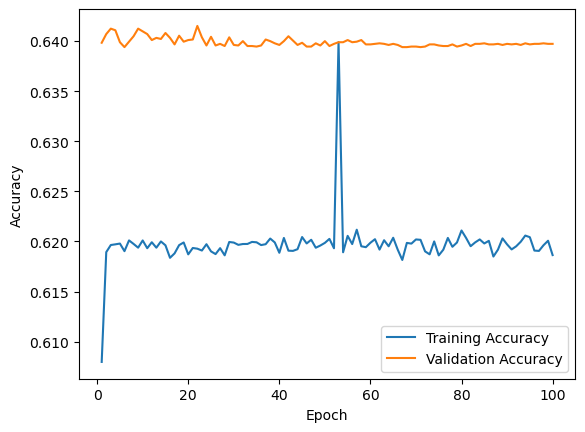

In [4]:
import matplotlib.pyplot as plt

# plot the training and validation accuracy
training_accuracy = [
    0.6079783664737697, 0.6189385119208071, 0.6196468206401734, 0.6197156441594641, 0.6197930706186661, 0.6190331442598317, 0.6201085117487483, 0.6197557912123837, 0.6193829971495592, 0.6201027764554741, 0.6193285118634542, 0.6199249823639732, 0.6193801295029221, 0.6200024088231751, 0.6196181441738023, 0.6183707178866591, 0.6188123354687742, 0.619635350053625, 0.6199020411908763, 0.6187148354831125, 0.619351453036551, 0.6192826295172603, 0.6190962324858482, 0.6197271147460125, 0.619013070733372, 0.6187406443028465, 0.6193342471567284, 0.6186173354974507, 0.6199507911837072, 0.6198905706043278, 0.6196640265199961, 0.6197471882724723, 0.6197529235657465, 0.6199565264769814, 0.619919247070699, 0.6196410853468992, 0.6197299823926496, 0.6202920411335233, 0.6199049088375134, 0.6188725560481535, 0.6203522617129027, 0.6190818942526626, 0.6190618207262029, 0.6192310118777924, 0.6204440264052903, 0.6198045412052146, 0.6201715999747647, 0.619377261856285, 0.6195952030007055, 0.6198618941379568, 0.6202604970205151, 0.6193227765701799, 0.6196754971065446, 0.6189241736876215, 0.6205615999174118, 0.6197414529791981, 0.6211752762977535, 0.6195206441881406, 0.6194317471423901, 0.6198733647245052, 0.6202289529075069, 0.6191908648248728, 0.6201257176285709, 0.6195206441881406, 0.6203723352393624, 0.6191793942383244, 0.6181556443888758, 0.6198590264913196, 0.6197873353253919, 0.6202031440877729, 0.6201658646814905, 0.619013070733372, 0.6187177031297495, 0.6200052764698123, 0.6186116002041765, 0.6191793942383244, 0.6203551293595398, 0.6194690265486725, 0.6198991735442392, 0.6210978498385515, 0.6203579970061769, 0.6195292471280519, 0.6199106441307877, 0.62020601173441, 0.6198016735585774, 0.6200654970491916, 0.618496894338692, 0.6191851295315985, 0.620309247013346, 0.619712776512827, 0.6192080707046955, 0.6195177765415034, 0.6199737323568041, 0.6205902763837828, 0.6204296881721046, 0.6190933648392111, 0.6190589530795657, 0.6196238794670765, 0.6200740999891029, 0.6186431443171847]

validation_accuracy = [
    0.6398351052289, 0.6407029724452159, 0.6412453894554133, 0.6410826643523541, 0.6398893469299197, 0.6394011716207421, 0.6399435886309395, 0.6404860056411369, 0.6412453894554133, 0.6409741809503146, 0.6407029724452159, 0.6401063137339987, 0.6403232805380776, 0.6402147971360382, 0.6408114558472554, 0.6403232805380776, 0.6396723801258407, 0.6405402473421566, 0.6399435886309395, 0.6401063137339987, 0.6401605554350185, 0.6415165979605121, 0.6403775222390974, 0.6395638967238012, 0.6404317639401171, 0.6395638967238012, 0.6397266218268605, 0.6395096550227816, 0.6403775222390974, 0.639618138424821, 0.6395638967238012, 0.6399978303319592, 0.6395096550227816, 0.6395096550227816, 0.6394554133217618, 0.6395638967238012, 0.6401605554350185, 0.6399978303319592, 0.6397808635278802, 0.639618138424821, 0.6399978303319592, 0.6404860056411369, 0.640052072032979, 0.639618138424821, 0.6398351052289, 0.6394554133217618, 0.6394554133217618, 0.6397808635278802, 0.6395638967238012, 0.6399978303319592, 0.6395096550227816, 0.6397266218268605, 0.6398893469299197, 0.6398893469299197, 0.6401063137339987, 0.6398893469299197, 0.6399435886309395, 0.6401063137339987, 0.6396723801258407, 0.6396723801258407, 0.6397266218268605, 0.6397808635278802, 0.6397266218268605, 0.639618138424821, 0.6397266218268605, 0.639618138424821, 0.6394011716207421, 0.6394011716207421, 0.6394554133217618, 0.6394554133217618, 0.6394011716207421, 0.6394554133217618, 0.6396723801258407, 0.6396723801258407, 0.6395638967238012, 0.6395096550227816, 0.6395096550227816, 0.6396723801258407, 0.6394554133217618, 0.6395638967238012, 0.6397266218268605, 0.6395096550227816, 0.6397266218268605, 0.6397266218268605, 0.6397808635278802, 0.6396723801258407, 0.6396723801258407, 0.6397266218268605, 0.639618138424821, 0.6397266218268605, 0.6396723801258407, 0.6397266218268605, 0.639618138424821, 0.6397808635278802, 0.6396723801258407, 0.6397266218268605, 0.6397266218268605, 0.6397808635278802, 0.6397266218268605, 0.6397266218268605]

plt.plot(np.arange(1, 101), training_accuracy, label='Training Accuracy')
plt.plot(np.arange(1, 101), validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
